# Implementation step by step

In [41]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [42]:
# fake a synthetic data
def synthetic_data(w, b, num_examples):
    """create a function: y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    
    return X, y.reshape((-1, 1))  # reshape y as a column vector

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# features, labels

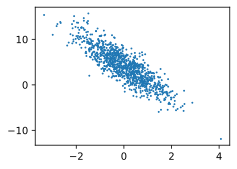

In [43]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

In [44]:
def data_iter(batch_size, features, labels):
    """generate a batch"""
    num_examples = len(features)
    indices = list(range(num_examples))
    # random read
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

# each loop generate one batch which contains 10 rows of data        
for X, y in data_iter(10, features, labels):
    print(X, '\n', y)
    break   # if do not break, data_inter function will iterate through all indices  

tensor([[-1.4440,  0.9555],
        [-1.1413, -1.3489],
        [ 0.7351, -0.5509],
        [ 2.1121, -0.0478],
        [ 0.0179,  0.9812],
        [-0.3879,  0.4138],
        [-0.4878, -0.5670],
        [-0.7757, -0.3315],
        [-1.4204, -0.6256],
        [ 0.2985,  0.5082]]) 
 tensor([[-1.9431],
        [ 6.4962],
        [ 7.5341],
        [ 8.5936],
        [ 0.8964],
        [ 2.0082],
        [ 5.1551],
        [ 3.8006],
        [ 3.4815],
        [ 3.0733]])


In [45]:
# initialize model parameter
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [46]:
def linreg(X, w, b):
    """define linear regression model"""
    return torch.matmul(X, w) + b

In [47]:
def squared_loss(y_hat, y):
    """define loss function using squared loss"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [48]:

def sgd(params, lr, batch_size):
    """
    define optimization function using stochastic gradient descent approach
    param : a list of parameter
    lr : learning rate
    """
    # do not update gradient, the gradient calculation do not involve 
    with torch.no_grad():
        for param in params:
            param -= (lr * param.grad) / batch_size
            param.grad.zero_()  # set gradient as none after each iteration
                                # by default in Pytorch, gradients are accumulated instead of overwritten 

In [49]:
# define hyperparameter
lr = 0.03
batch_size = 10
num_epoch = 3   # scan the entire dataset 3 times
net = linreg
loss = squared_loss

for epoch in range(num_epoch):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch: {epoch + 1}, loss: {train_l.mean()}')

epoch: 1, loss: 0.04796664044260979
epoch: 2, loss: 0.0001967743446584791
epoch: 3, loss: 4.6045566705288365e-05


In [50]:
w, b

(tensor([[ 1.9992],
         [-3.3988]], requires_grad=True),
 tensor([4.1999], requires_grad=True))

# implementation using framework

In [51]:
import numpy as np
from torch.utils import data
import torch
from d2l import torch as d2l

In [52]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [53]:
def load_array(data_arrays, batch_size, is_train=True):
    """construct a pytorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# create a iterator from data_iter iterable
next(iter(data_iter))

[tensor([[ 0.1968,  1.1417],
         [-1.1644, -1.6148],
         [-0.3355,  1.4800],
         [-0.0243, -1.4163],
         [-0.3363, -0.4339],
         [ 0.8176, -0.0667],
         [-0.1720, -0.3049],
         [-0.2030,  0.3886],
         [-0.8539, -0.1038],
         [ 1.2087, -0.4598]]),
 tensor([[ 0.6907],
         [ 7.3558],
         [-1.4891],
         [ 8.9651],
         [ 5.0069],
         [ 6.0666],
         [ 4.8773],
         [ 2.4805],
         [ 2.8365],
         [ 8.1737]])]

In [54]:
from torch import nn

In [55]:
# nn define different type of neural network layer
# Sequential is a container that contains a list of layers in order
# nn.Linear(input_dim, output_dim) define a fully connected layer (linear layer)
net = nn.Sequential(nn.Linear(2, 1))

# visit current layer, call weight to get 'w', then use normal distribution to fill the value
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [56]:
# use L2 norm to compute loss, which also called MSE loss
loss = nn.MSELoss()

In [57]:
# torch.optim defines multiple optimization approach
# must input 2 parameter: params for training model, and learning rate
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [58]:
# train
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()  # set gradient as none for next iteration
        l.backward()         # pytorch already sum up 'l'
        trainer.step()       # update params one time using optimization approach
    l = loss(net(features), labels)
    print(f'epoch: {epoch + 1}, loss: {l}')

epoch: 1, loss: 0.0004914957680739462
epoch: 2, loss: 9.983666677726433e-05
epoch: 3, loss: 9.856199903879315e-05
